# Tennis_atp analysis


In [18]:
import pandas as pd
import os
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.graph_objects as go

In [19]:
from glob import glob
import os
import pandas as pd

folder_path = os.path.expanduser("~/SmashData/data/atp_mens_tour")  # or absolute path

all_files = glob(os.path.join(folder_path, "*.xls*"))
print("🗂️ Fichiers Excel trouvés:", all_files)


# 2. Load files into DataFrames
dataframes = []
for file in all_files:
    try:
        # Extract year from filename like '2003.xls'
        year = os.path.splitext(os.path.basename(file))[0]
        df = pd.read_excel(file)
        df["Year"] = int(year)
        dataframes.append(df)
        print(f"✅ Chargé : {file} avec shape {df.shape}")
    except Exception as e:
        print(f"❌ Erreur lors du chargement de {file} : {e}")

# 3. Check before concatenation
print(f"\n📊 Nombre total de DataFrames chargés: {len(dataframes)}")
if not dataframes:
    raise ValueError("🚫 Aucun DataFrame à concaténer.")

# 4. Harmonize columns
all_columns = set(col for df in dataframes for col in df.columns)
for i in range(len(dataframes)):
    missing_cols = all_columns - set(dataframes[i].columns)
    for col in missing_cols:
        dataframes[i][col] = pd.NA
    dataframes[i] = dataframes[i][sorted(all_columns)]

# 5. Concatenate
merged_df = pd.concat(dataframes, ignore_index=True)
print("🎉 Fusion réussie ! Dimensions :", merged_df.shape)


🗂️ Fichiers Excel trouvés: ['/Users/karine/SmashData/data/atp_mens_tour/2021.xlsx', '/Users/karine/SmashData/data/atp_mens_tour/2006.xls', '/Users/karine/SmashData/data/atp_mens_tour/2012.xls', '/Users/karine/SmashData/data/atp_mens_tour/2007.xls', '/Users/karine/SmashData/data/atp_mens_tour/2011.xls', '/Users/karine/SmashData/data/atp_mens_tour/2005.xls', '/Users/karine/SmashData/data/atp_mens_tour/2004.xls', '/Users/karine/SmashData/data/atp_mens_tour/2010.xls', '/Users/karine/SmashData/data/atp_mens_tour/2017.xlsx', '/Users/karine/SmashData/data/atp_mens_tour/2016.xlsx', '/Users/karine/SmashData/data/atp_mens_tour/2000.xls', '/Users/karine/SmashData/data/atp_mens_tour/2001.xls', '/Users/karine/SmashData/data/atp_mens_tour/2003.xls', '/Users/karine/SmashData/data/atp_mens_tour/2020.xlsx', '/Users/karine/SmashData/data/atp_mens_tour/2002.xls', '/Users/karine/SmashData/data/atp_mens_tour/2013.xlsx', '/Users/karine/SmashData/data/atp_mens_tour/2019.xlsx', '/Users/karine/SmashData/data/a

/Users/karine/opt/miniconda3/lib/python3.10/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


✅ Chargé : /Users/karine/SmashData/data/atp_mens_tour/2016.xlsx avec shape (2626, 41)
✅ Chargé : /Users/karine/SmashData/data/atp_mens_tour/2000.xls avec shape (2963, 27)
✅ Chargé : /Users/karine/SmashData/data/atp_mens_tour/2001.xls avec shape (2963, 35)
✅ Chargé : /Users/karine/SmashData/data/atp_mens_tour/2003.xls avec shape (2861, 37)
✅ Chargé : /Users/karine/SmashData/data/atp_mens_tour/2020.xlsx avec shape (1267, 37)
✅ Chargé : /Users/karine/SmashData/data/atp_mens_tour/2002.xls avec shape (2854, 37)


/Users/karine/opt/miniconda3/lib/python3.10/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


✅ Chargé : /Users/karine/SmashData/data/atp_mens_tour/2013.xlsx avec shape (2631, 43)
✅ Chargé : /Users/karine/SmashData/data/atp_mens_tour/2019.xlsx avec shape (2610, 37)
✅ Chargé : /Users/karine/SmashData/data/atp_mens_tour/2023.xlsx avec shape (1996, 37)


/Users/karine/opt/miniconda3/lib/python3.10/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


✅ Chargé : /Users/karine/SmashData/data/atp_mens_tour/2015.xlsx avec shape (2630, 41)
✅ Chargé : /Users/karine/SmashData/data/atp_mens_tour/2009.xls avec shape (2731, 39)
✅ Chargé : /Users/karine/SmashData/data/atp_mens_tour/2008.xls avec shape (2707, 39)


/Users/karine/opt/miniconda3/lib/python3.10/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


✅ Chargé : /Users/karine/SmashData/data/atp_mens_tour/2014.xlsx avec shape (2600, 43)
✅ Chargé : /Users/karine/SmashData/data/atp_mens_tour/2022.xlsx avec shape (2632, 37)
✅ Chargé : /Users/karine/SmashData/data/atp_mens_tour/2018.xlsx avec shape (2637, 41)

📊 Nombre total de DataFrames chargés: 24
🎉 Fusion réussie ! Dimensions : (63292, 55)


In [20]:
merged_df

,ATP,AvgL,AvgW,B&WL,B&WW,B365L,B365W,Best of,CBL,CBW,...,W1,W2,W3,W4,W5,WPts,WRank,Winner,Wsets,Year
0,1,2.42,1.56,NaN,NaN,2.5,1.5,3.0,NaN,NaN,...,4.0,7.0,6.0,NaN,NaN,1395,40,Basilashvili N.,2.0,2021
1,1,1.5,2.57,NaN,NaN,1.5,2.5,3.0,NaN,NaN,...,7.0,7.0,NaN,NaN,NaN,150,309,Celikbilek A.,2.0,2021
2,1,2.53,1.52,NaN,NaN,2.5,1.5,3.0,NaN,NaN,...,6.0,7.0,NaN,NaN,NaN,806,87,Ruusuvuori E.,2.0,2021
3,1,2.11,1.72,NaN,NaN,2.2,1.61,3.0,NaN,NaN,...,6.0,6.0,NaN,NaN,NaN,1090,49,Bublik A.,2.0,2021
4,1,2.78,1.44,NaN,NaN,2.75,1.4,3.0,NaN,NaN,...,3.0,7.0,6.0,NaN,NaN,2555,16,Goffin D.,2.0,2021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63287,67,3.14,1.38,NaN,NaN,3.2,1.36,3.0,NaN,NaN,...,7.0,6.0,NaN,NaN,NaN,5085,5,Zverev A.,2.0,2018
63288,67,5.14,1.17,NaN,NaN,4.5,1.2,3.0,NaN,NaN,...,7.0,6.0,NaN,NaN,NaN,8045,1,Djokovic N.,2.0,2018
63289,67,1.38,3.14,NaN,NaN,1.36,3.2,3.0,NaN,NaN,...,7.0,7.0,NaN,NaN,NaN,5085,5,Zverev A.,2.0,2018
63290,67,6.52,1.12,NaN,NaN,7.0,1.11,3.0,NaN,NaN,...,6.0,6.0,NaN,NaN,NaN,8045,1,Djokovic N.,2.0,2018


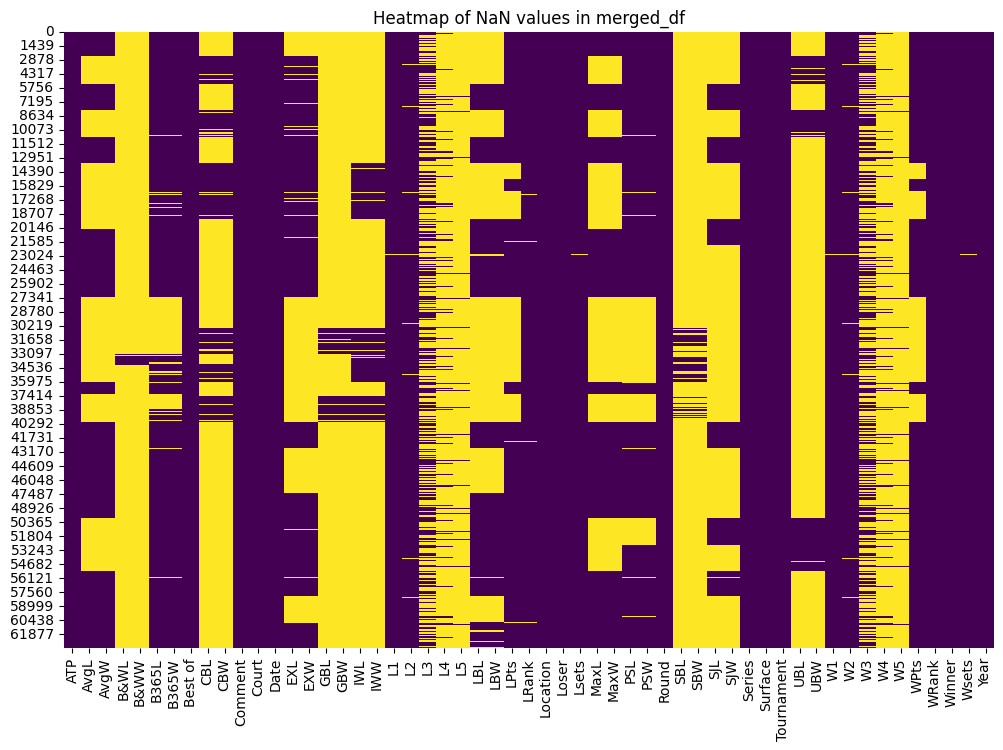

In [17]:
# Set the size of the plot
plt.figure(figsize=(12, 8))

# Create a heatmap to visualize NaN values
sns.heatmap(merged_df.isna(), cbar=False, cmap='viridis')

# Set the title of the plot
plt.title('Heatmap of NaN values in merged_df')

# Show the plot
plt.show()

In [26]:
# Save the merged_df DataFrame to a CSV file
merged_df.to_csv("match_tennis_68_ajd.csv", index=False)

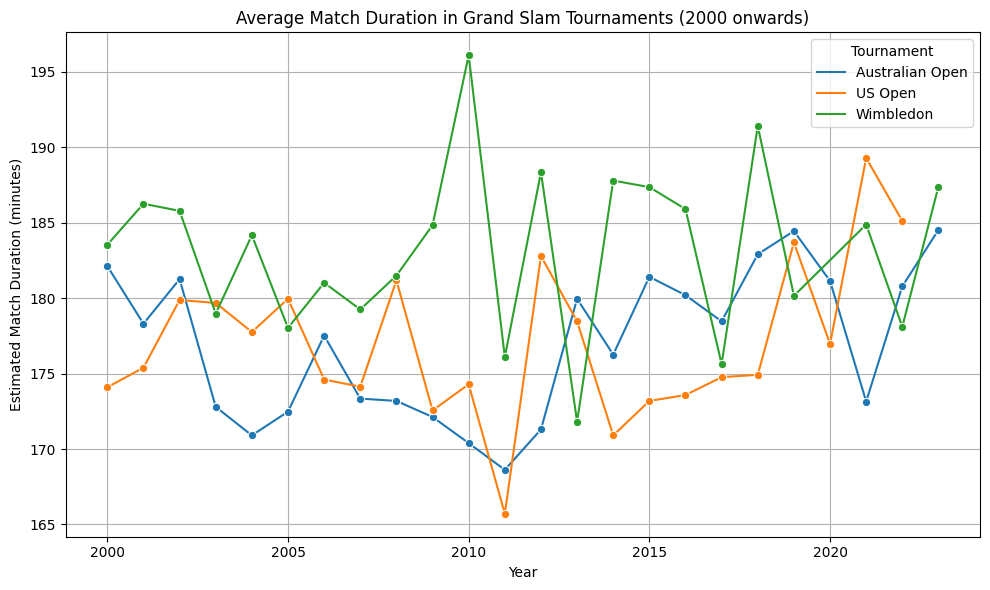

In [29]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Estimate match duration by counting total games played (approximate)
def estimate_minutes(row):
    sets = []
    for i in range(1, 6):
        w = pd.to_numeric(row.get(f'W{i}', 0), errors='coerce')
        l = pd.to_numeric(row.get(f'L{i}', 0), errors='coerce')
        total = 0
        if pd.notna(w): total += w
        if pd.notna(l): total += l
        sets.append(total)
    total_games = sum(sets)
    avg_minutes_per_game = 5  # Estimate: 5 minutes per game
    return total_games * avg_minutes_per_game


# Add estimated 'minutes' column
merged_df['minutes'] = merged_df.apply(estimate_minutes, axis=1)

# Use 'Tournament' and 'Year' for grouping
minutes_by_tourney = merged_df.groupby(['Tournament', 'Year'])['minutes'].mean().reset_index()

# Filter for Grand Slam tournaments only
grand_slams = ['Roland Garros', 'US Open', 'Australian Open', 'Wimbledon']
filtered_minutes_by_tourney = minutes_by_tourney[minutes_by_tourney['Tournament'].isin(grand_slams)]

# Filter for years 2000 and later
filtered_minutes_by_tourney = filtered_minutes_by_tourney[filtered_minutes_by_tourney['Year'] >= 2000]

# Plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=filtered_minutes_by_tourney, x='Year', y='minutes', hue='Tournament', marker='o')

plt.title('Average Match Duration in Grand Slam Tournaments (2000 onwards)')
plt.ylabel('Estimated Match Duration (minutes)')
plt.xlabel('Year')
plt.grid(True)
plt.tight_layout()
plt.show()


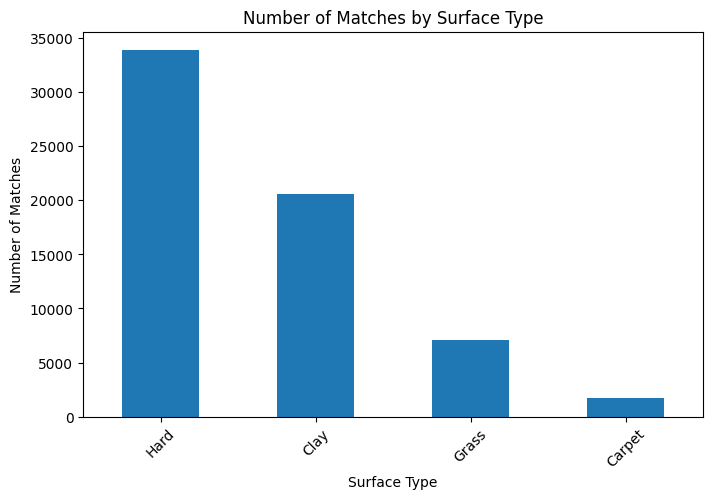

In [31]:
# Count the number of matches per surface
surface_counts = merged_df["Surface"].value_counts()

# Plot the bar chart
plt.figure(figsize=(8, 5))
surface_counts.plot(kind="bar")
plt.title("Number of Matches by Surface Type")
plt.xlabel("Surface Type")
plt.ylabel("Number of Matches")
plt.xticks(rotation=45)
plt.show()

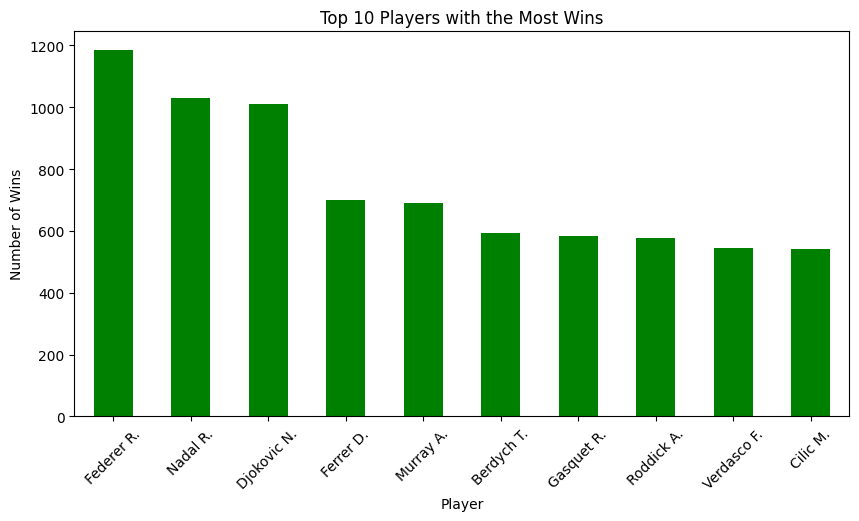

In [33]:
# Count the number of wins per player
winners = merged_df["Winner"].value_counts().head(10)

# Plot the bar chart
plt.figure(figsize=(10, 5))
winners.plot(kind="bar", color="green")
plt.title("Top 10 Players with the Most Wins")
plt.xlabel("Player")
plt.ylabel("Number of Wins")
plt.xticks(rotation=45)
plt.show()


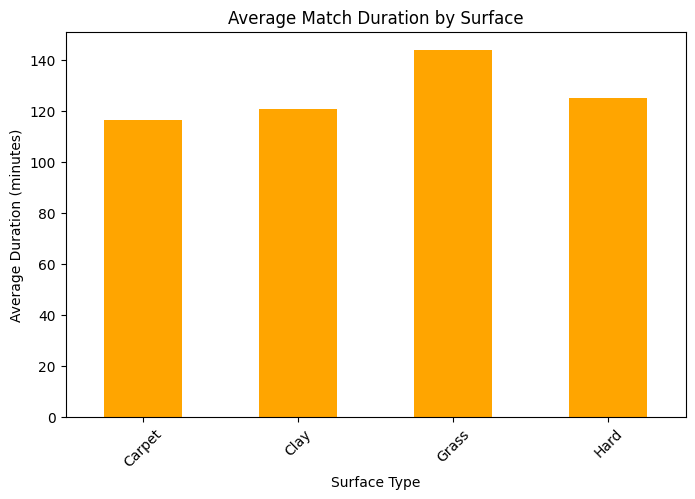

In [34]:
# Compute the average match duration by surface
avg_match_duration = merged_df.groupby("Surface")["minutes"].mean()

# Plot the bar chart
plt.figure(figsize=(8, 5))
avg_match_duration.plot(kind="bar", color="orange")
plt.title("Average Match Duration by Surface")
plt.xlabel("Surface Type")
plt.ylabel("Average Duration (minutes)")
plt.xticks(rotation=45)
plt.show()


In [36]:
# Step 1: Check if 'score' column exists
if 'score' not in merged_df.columns:
    raise KeyError("'score' column not found in dataset — check if it exists or if it's named differently.")

# Step 2: Ensure 'score' is string, then count '7-6'
merged_df['tiebreaks'] = merged_df['score'].fillna('').astype(str).apply(lambda x: x.count('7-6'))

# Step 3: Group by year and sum the number of tiebreaks
tie_breaks_per_year = merged_df.groupby('Year')['tiebreaks'].sum().sort_index()

# Step 4: Plot
plt.figure(figsize=(10, 5))
plt.plot(tie_breaks_per_year.index, tie_breaks_per_year.values, marker="o", linestyle="-")
plt.title("Evolution of Tie-Break Matches Over the Years")
plt.xlabel("Year")
plt.ylabel("Number of Tie-Breaks")
plt.grid(True)
plt.tight_layout()
plt.show()


KeyError: "'score' column not found in dataset — check if it exists or if it's named differently."

In [37]:
# Select a player
player = "Roger Federer"

# Count wins and losses
wins = (merged_df["winner_name"] == player).sum()
losses = (merged_df["loser_name"] == player).sum()

# Plot the pie chart
plt.figure(figsize=(6, 6))
plt.pie([wins, losses], labels=["Wins", "Losses"], autopct="%1.1f%%", colors=["green", "red"])
plt.title(f"Win/Loss Ratio of {player}")
plt.show()

KeyError: 'winner_name'

In [38]:
# Filter matches between 2000 and 2023
filtered_df = merged_df[(merged_df["Year"] >= 2000) & (merged_df["Year"] <= 2023)]

# Count the number of wins per player
wins = filtered_df["winner_name"].value_counts()

# Count the number of losses per player
losses = filtered_df["loser_name"].value_counts()

# Merge win and loss counts, filling missing values with 0
player_stats = pd.DataFrame({"Wins": wins, "Losses": losses}).fillna(0)

# Calculate win percentage
player_stats["Total Matches"] = player_stats["Wins"] + player_stats["Losses"]
player_stats["Win Percentage"] = (player_stats["Wins"] / player_stats["Total Matches"]) * 100

# Select the top 10 players based on total matches played
top_10_players = player_stats.sort_values(by="Total Matches", ascending=False).head(10)

# Sort players by win percentage
top_10_sorted = top_10_players.sort_values(by="Win Percentage", ascending=False)

# Plot the bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x=top_10_sorted["Win Percentage"], y=top_10_sorted.index, palette="viridis")

# Add labels and title
plt.xlabel("Win Percentage (%)")
plt.ylabel("Player")
plt.title("Top 10 Players Win Percentage (2000-2023)")

# Display the values on the bars
for index, value in enumerate(top_10_sorted["Win Percentage"]):
    plt.text(value + 1, index, f"{value:.1f}%", va="center")

plt.xlim(0, 100)
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.show()

KeyError: 'winner_name'

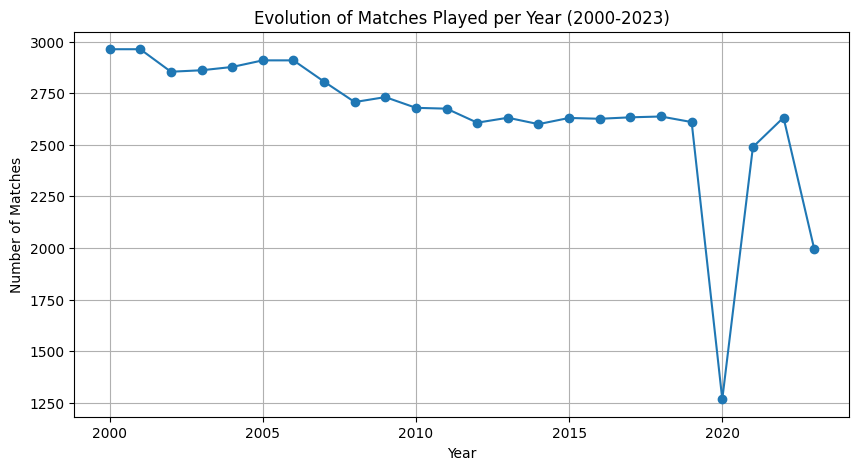

In [39]:
matches_per_year = merged_df[merged_df["Year"] >= 2000]["Year"].value_counts().sort_index()
plt.figure(figsize=(10, 5))
plt.plot(matches_per_year.index, matches_per_year.values, marker="o", linestyle="-")
plt.title("Evolution of Matches Played per Year (2000-2023)")
plt.xlabel("Year")
plt.ylabel("Number of Matches")
plt.grid(True)
plt.show()


In [ ]:
plt.figure(figsize=(10, 5))
sns.histplot(merged_df[merged_df["Year"] >= 2000]["minutes"].dropna(), bins=30, kde=True)
plt.title("Distribution of Match Durations (2000-2023)")
plt.xlabel("Duration (Minutes)")
plt.ylabel("Frequency")
plt.show()


In [40]:
surface_counts = merged_df[merged_df["Year"] >= 2000]["surface"].value_counts()
plt.figure(figsize=(8, 5))
surface_counts.plot(kind="bar", color=["blue", "brown", "green"])
plt.title("Number of Matches by Surface Type (2000-2023)")
plt.xlabel("Surface")
plt.ylabel("Number of Matches")
plt.show()


KeyError: 'surface'

In [ ]:
plt.figure(figsize=(8, 5))
sns.boxplot(x=merged_df[merged_df["Year"] >= 2000]["surface"], 
            y=merged_df[merged_df["Year"] >= 2000]["minutes"])
plt.title("Comparison of Match Duration by Surface (2000-2023)")
plt.xlabel("Surface")
plt.ylabel("Match Duration (Minutes)")
plt.show()


In [ ]:
top_titles = merged_df[merged_df["Year"] >= 2000]["winner_name"].value_counts().head(10)
plt.figure(figsize=(10, 5))
sns.barplot(x=top_titles.values, y=top_titles.index, palette="magma")
plt.title("Top 10 Players with Most ATP Matches win (2000-2023)")
plt.xlabel("Number of Titles")
plt.ylabel("Player")
plt.show()

In [ ]:
player1 = "Roger Federer"
player2 = "Rafael Nadal"

matches = merged_df[(merged_df["Year"] >= 2000) & 
                    (((merged_df["winner_name"] == player1) & (merged_df["loser_name"] == player2)) |
                     ((merged_df["winner_name"] == player2) & (merged_df["loser_name"] == player1)))]

wins_p1 = (matches["winner_name"] == player1).sum()
wins_p2 = (matches["winner_name"] == player2).sum()

plt.figure(figsize=(6, 6))
plt.pie([wins_p1, wins_p2], labels=[player1, player2], autopct="%1.1f%%", colors=["blue", "red"])
plt.title(f"Head-to-Head: {player1} vs {player2} (2000-2023)")
plt.show()


In [ ]:
grand_slam_events = ["Australian Open", "Roland Garros", "Wimbledon", "US Open"]
gs_wins = merged_df[(merged_df["Year"] >= 2000) & merged_df["tourney_name"].isin(grand_slam_events)]
big3 = gs_wins[gs_wins["winner_name"].isin(["Roger Federer", "Rafael Nadal", "Novak Djokovic"])]

plt.figure(figsize=(10, 5))
for player in big3["winner_name"].unique():
    player_gs = big3[big3["winner_name"] == player]["Year"].value_counts().sort_index()
    plt.plot(player_gs.index, player_gs.values, marker="o", label=player)

plt.title("Grand Slam Matches win Over Time (Federer, Nadal, Djokovic) (2000-2023)")
plt.xlabel("Year")
plt.ylabel("Matches Won")
plt.legend()
plt.show()


In [ ]:
grand_slam_events = ["Australian Open", "Roland Garros", "Wimbledon", "US Open"]
ngs_wins = merged_df[(merged_df["Year"] >= 2000) & (~merged_df["tourney_name"].isin(grand_slam_events))]
big3 = ngs_wins[ngs_wins["winner_name"].isin(["Roger Federer", "Rafael Nadal", "Novak Djokovic"])]

plt.figure(figsize=(10, 5))
for player in big3["winner_name"].unique():
    player_gs = big3[big3["winner_name"] == player]["Year"].value_counts().sort_index()
    plt.plot(player_gs.index, player_gs.values, marker="o", label=player)

plt.title("Non-Grand Slam Matches win Over Time (Federer, Nadal, Djokovic) (2000-2023)")
plt.xlabel("Year")
plt.ylabel("Matches Won")
plt.legend()
plt.show()

In [ ]:
# Filter only Grand Slam finals from 2000 onwards
grand_slam_events = ["Australian Open", "Roland Garros", "Wimbledon", "US Open"]
big3_names = ["Roger Federer", "Rafael Nadal", "Novak Djokovic"]

# Filter finals only
gs_finals = merged_df[
    (merged_df["Year"] >= 2000) &
    (merged_df["tourney_name"].isin(grand_slam_events)) &
    (merged_df["round"] == "F") &
    (merged_df["winner_name"].isin(big3_names))
]

# Create a pivot table: rows = player, columns = tournament, values = count of wins
pivot = gs_finals.pivot_table(index="winner_name", columns="tourney_name", aggfunc="size", fill_value=0)

# Define a custom color map keeping previous colors and setting Wimbledon to green
custom_colors = {
    "Australian Open": "#1f77b4",  # Blue
    "Roland Garros": "#ff9848",  # Orange
    "US Open": "#9283be",  # Purple
    "Wimbledon": "#4CAF50"  # Green (Grass)
}

plt.figure(figsize=(12, 8))  # Augmenter la taille du plot

# Plot the stacked bar chart
pivot = pivot.reindex(big3_names)  # Ensure order
# Plot the stacked bar chart with the custom colors
pivot.plot(kind="bar", stacked=True, figsize=(10, 6), color=[custom_colors[col] for col in pivot.columns])

# Ajouter les totaux au sommet de chaque barre
total_titles = pivot.sum(axis=1)  # Calculer le total par joueur
for index, total in enumerate(total_titles):
    plt.text(index, total, str(int(total)), ha="center", va="bottom", fontsize=12, fontweight="bold", color="black")

# Title and labels
plt.title("Grand Slam Titles by Tournament (Big 3, 2000–2023)")
plt.xlabel("Player")
plt.ylabel("Number of Titles")
plt.legend(title="Tournament", fontsize=7, title_fontsize=10)  # Taille du texte réduiteplt.tight_layout()
plt.show()


In [ ]:
# Get the top 100 players based on total wins
n = 4
top_100_players = wins.head(n).index

# Filter the merged_df to include only matches won by the top 100 players
top_100_wins = merged_df[merged_df["winner_name"].isin(top_100_players)]

# Group by Year and winner_name, then count the number of wins
wins_over_time = top_100_wins.groupby(["Year", "winner_name"]).size().unstack(fill_value=0)

# Plot the wins over time
plt.figure(figsize=(14, 8))
wins_over_time.plot(ax=plt.gca(), legend=False, alpha=0.7)

# Add labels and title
plt.xlabel("Year")
plt.ylabel("Wins")
plt.title(f"Cumulative Wins of Top {n} Players Over Time")
plt.grid(True)
plt.legend(title="Player", bbox_to_anchor=(1, 1))
plt.show()

In [ ]:
# Find unique locations and their occurrences
# Import match_tennis data
men_historic = pd.read_csv('match_tennis_68_ajd.csv')
location_counts = men_historic['tourney_name'].value_counts().reset_index()
location_counts.columns = ['tourney_name', 'Occurrences']

# Display the DataFrame
location_counts.head(50)

# Atp_mens tour

In [41]:
import pandas as pd
import glob
import os

# Chemin vers le dossier contenant les fichiers CSV
path = 'csv_data/atp_mens_tour/'

# Liste tous les fichiers CSV dans le dossier (utilisation correcte de glob.glob)
csv_files = glob.glob(os.path.join(path, "*.csv"))

# Liste pour stocker les dataframes
df_list = []

# Parcourt chaque fichier CSV
for file in csv_files:
    # Extraction de l'année depuis le nom du fichier
    year = os.path.basename(file).split(".")[0]

    # Lecture du fichier CSV
    df = pd.read_csv(file)

    # Ajout de la colonne year
    df['year'] = int(year)

    # Ajout du dataframe à la liste
    df_list.append(df)

# Fusionne tous les dataframes en un seul
atp_mens_tour_merged = pd.concat(df_list, ignore_index=True)

# Sauvegarde le résultat dans un nouveau fichier CSV
atp_mens_tour_merged.to_csv('atp_mens_tour_merged.csv', index=False)

print("Les fichiers CSV ont été fusionnés avec succès dans 'atp_mens_tour_merged.csv'.")


ValueError: No objects to concatenate

In [ ]:
atp_mens_tour_merged

In [ ]:
# Set the size of the plot
plt.figure(figsize=(12, 8))

# Create a heatmap to visualize NaN values
sns.heatmap(atp_mens_tour_merged.isna(), cbar=False, cmap='viridis')

# Set the title of the plot
plt.title('Heatmap of NaN values in merged_df')

# Show the plot
plt.show()

In [ ]:
# Filter the data to include only the final round matches
final_round_matches = atp_mens_tour_merged[atp_mens_tour_merged['Round'] == 'The Final']

# Count the number of wins per player in the final round
final_round_winners = final_round_matches['Winner'].value_counts().head(10)

# Plot the bar chart
plt.figure(figsize=(10, 5))
final_round_winners.plot(kind="bar", color="purple")
plt.title("Top 10 Players with the Most Final Round Wins")
plt.xlabel("Player")
plt.ylabel("Number of Wins")
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Calculate the percentage of finals won by each player
final_round_winners_percentage = (final_round_winners / final_round_winners.sum()) * 100

# Plot the bar chart with percentages
plt.figure(figsize=(10, 5))
final_round_winners_percentage.plot(kind="bar", color="purple")
plt.title("Top 10 Players with the Most Final Round Wins (Percentage)")
plt.xlabel("Player")
plt.ylabel("Percentage of Wins")
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Nombre de top joueurs à considérer
top_n = 4

# Calculer le nombre total de victoires par joueur
top_winners = atp_mens_tour_merged['Winner'].value_counts().head(top_n).index

# Filtrer les données pour ne garder que les victoires des top joueurs
top_data = atp_mens_tour_merged[atp_mens_tour_merged['Winner'].isin(top_winners)]

# Compter le nombre de victoires par joueur et par année
wins_per_year = top_data.groupby(['year', 'Winner']).size().unstack(fill_value=0)

# Tracer le graphique
plt.figure(figsize=(12, 7))
wins_per_year.plot(marker='o', ax=plt.gca())
plt.title(f'Nombre de victoires par an pour les {top_n} meilleurs joueurs ATP')
plt.xlabel('Année')
plt.ylabel('Nombre de victoires')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(title='Joueur')
plt.tight_layout()
plt.show()

In [ ]:
# Choix du top n joueurs
top_n = 4

# Obtenir les top n joueurs selon le nombre total de victoires
top_players = atp_mens_tour_merged['Winner'].value_counts().head(top_n).index

# Filtrer les données pour les matchs entre joueurs du top n seulement
duels_top_players = atp_mens_tour_merged[atp_mens_tour_merged['Winner'].isin(top_players) & atp_mens_tour_merged['Loser'].isin(top_players)]

# Calculer les victoires pour chaque paire (Winner -> Loser)
duel_counts = duels_top_players.groupby(['Winner', 'Loser']).size().unstack(fill_value=0)

# Pour chaque joueur, trouver le joueur qui l'a battu le plus souvent
most_defeated_by = duel_counts.idxmax(axis=0)
defeats_count = duel_counts.max(axis=0)

# Plot statique montrant le joueur qui gagne le plus contre chaque joueur du top n
plt.figure(figsize=(12, 7))
bars = plt.barh(defeats_count.index, defeats_count.values, color='coral')

# Ajouter les labels du joueur dominant sur chaque barre
for bar, player in zip(bars, most_defeated_by):
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2,
             f' battu le plus souvent par {player}',
             va='center', ha='left', fontsize=10)

plt.title(f'Joueur qui gagne le plus contre chaque joueur du top {top_n}')
plt.xlabel('Nombre de défaites contre ce joueur')
plt.ylabel('Joueur')
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import plotly.graph_objects as go
import ipywidgets as widgets
from ipywidgets import interact

# Charger les données CSV fusionnées
data = pd.read_csv('atp_mens_tour_merged.csv')

# Définir la fonction interactive
def interactive_duel_analysis(top_n, player1, player2, tournament_series):
    top_players = data['Winner'].value_counts().head(top_n).index
    
    filtered_data = data[
        (data['Winner'].isin([player1, player2])) & 
        (data['Loser'].isin([player1, player2])) &
        (data['Series'].isin([tournament_series]) if tournament_series != 'All' else True)
    ]
    
    victories = filtered_data['Winner'].value_counts()
    total_matches = victories.sum()
    
    percent_player1 = (victories.get(player1, 0) / total_matches) * 100 if total_matches else 0
    percent_player2 = (victories.get(player2, 0) / total_matches) * 100 if total_matches else 0
    
    fig = go.Figure(go.Pie(labels=[player1, player2],
                           values=[percent_player1, percent_player2],
                           hole=0.3))
    
    fig.update_layout(title=f'% Victoires : {player1} vs {player2} ({tournament_series})',
                      annotations=[dict(text=f'{total_matches} matchs',
                                        x=0.5, y=0.5, font_size=20, showarrow=False)])
    fig.show()

# Widgets interactifs
def update_player_choices(top_n):
    players = data['Winner'].value_counts().head(top_n).index.tolist()
    player_dropdown.options = players
    player2_dropdown.options = players

top_n_slider = widgets.IntSlider(value=5, min=2, max=20, step=1, description='Top N:')
player_dropdown = widgets.Dropdown(options=[], description='Joueur 1:')
player2_dropdown = widgets.Dropdown(options=[], description='Joueur 2:')
series_options = ['All'] + sorted(data['Series'].dropna().unique().tolist())
series_dropdown = widgets.Dropdown(options=series_options, description='Tournoi:')

top_n_slider.observe(lambda change: update_player_choices(change['new']), names='value')
update_player_choices(top_n_slider.value)

interact(interactive_duel_analysis,
         top_n=top_n_slider,
         player1=player_dropdown,
         player2=player2_dropdown,
         tournament_series=series_dropdown)


In [ ]:
import pandas as pd
import numpy as np
from collections import defaultdict
from datetime import datetime

# --- ELO functions ---
def k_factor(matches_played):
    return 250 / (matches_played + 5) ** 0.4

def calc_exp_score(rA, rB):
    return 1 / (1 + 10 ** ((rB - rA) / 400))

def update_elo(old_elo, k, actual, expected):
    return old_elo + k * (actual - expected)

# --- Load dataset ---
df = pd.read_csv("match_tennis_68_ajd.csv")
#df = df[df["tourney_date"] >= 20000101]  # Optionnel : filtrer 2000–2024
df = df.sort_values(by="tourney_date")

# --- Init structures ---
players = {}

def init_player(pid, date):
    if pid not in players:
        players[pid] = {
            'player_id': pid,
            'elo': 1500,
            'elo_start': 1500,
            'elo_peak': 1500,
            'elo_peak_date': date,
            'first_match_date': date,
            'last_match_date': date,
            'matches_played': 0
        }

# --- Process matches ---
for _, row in df.iterrows():
    try:
        w, l = int(row['winner_id']), int(row['loser_id'])
        date = int(row['tourney_date'])
    except:
        continue

    for pid in [w, l]:
        init_player(pid, date)

    r_w = players[w]['elo']
    r_l = players[l]['elo']

    exp_w = calc_exp_score(r_w, r_l)
    exp_l = 1 - exp_w

    k_w = k_factor(players[w]['matches_played'])
    k_l = k_factor(players[l]['matches_played'])

    new_w = update_elo(r_w, k_w, 1, exp_w)
    new_l = update_elo(r_l, k_l, 0, exp_l)

    players[w]['elo'] = new_w
    players[l]['elo'] = new_l

    players[w]['matches_played'] += 1
    players[l]['matches_played'] += 1

    players[w]['last_match_date'] = date
    players[l]['last_match_date'] = date

    if new_w > players[w]['elo_peak']:
        players[w]['elo_peak'] = new_w
        players[w]['elo_peak_date'] = date
    if new_l > players[l]['elo_peak']:
        players[l]['elo_peak'] = new_l
        players[l]['elo_peak_date'] = date

# --- Create final DataFrame ---
player_stats = pd.DataFrame.from_dict(players, orient='index')
player_stats.rename(columns={'elo': 'elo_final'}, inplace=True)

# Convert dates to readable format
for col in ['first_match_date', 'last_match_date', 'elo_peak_date']:
    player_stats[col] = pd.to_datetime(player_stats[col], format='%Y%m%d')

# Save as CSV
player_stats.to_csv("player_elo_stats.csv", index=False)

# Show a preview
player_stats.head(10)

In [ ]:
atp_players = pd.read_csv('tennis_atp/atp_players.csv') 

In [ ]:
atp_players

In [ ]:
# Create a dictionary mapping player_id to player_name
player_id_to_name = dict(zip(atp_players['player_id'], atp_players['name_last']))

# Replace player_id with player_name in player_stats
player_stats['player_name'] = player_stats['player_id'].map(player_id_to_name)

# Drop the player_id column if no longer needed
player_stats.drop(columns=['player_id'], inplace=True)

# Display the updated player_stats DataFrame
player_stats.head()

In [ ]:
# Sort player_stats by peak Elo in descending order
sorted_player_stats = player_stats.sort_values(by='elo_peak', ascending=False)

# Display the sorted DataFrame
sorted_player_stats.head(10)

In [ ]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from ipywidgets import interact, IntSlider, Dropdown
from collections import defaultdict
from datetime import datetime

# --- Fonctions ELO ---
def k_factor(matches_played):
    return 250 / (matches_played + 5) ** 0.4

def calc_exp_score(rA, rB):
    return 1 / (1 + 10 ** ((rB - rA) / 400))

def update_elo(old_elo, k, actual, expected):
    return old_elo + k * (actual - expected)

# --- Charger les données ---
df_all = pd.read_csv("match_tennis_68_ajd.csv")
#df_all = df_all[df_all["tourney_date"] >= 20000101]
df_all['surface'] = df_all['surface'].fillna("Unknown")

# --- Liste des surfaces uniques ---
surfaces = df_all['surface'].dropna().unique().tolist()
surfaces.sort()
surfaces = ["All"] + surfaces


# --- Fonction principale ---
def compute_elo_and_plot(top_n=10, surface="All"):
    df = df_all.copy()
    if surface != "All":
        df = df[df['surface'] == surface]

    # Init structures
    player_elo = defaultdict(lambda: 1500)
    player_matches = defaultdict(int)
    player_peak = {}
    player_last_match = {}
    elo_history = defaultdict(list)
    dates = []

    # Tri chronologique
    round_order = ['RR', 'R128', 'R64', 'R32', 'R16', 'QF', 'SF', 'F']
    df['round'] = pd.Categorical(df['round'], categories=round_order, ordered=True)
    df = df.sort_values(by=['tourney_date', 'round'])

    # Calculs ELO
    for _, row in df.iterrows():
        try:
            w, l = row['winner_name'], row['loser_name']
            date = int(row['tourney_date'])
        except:
            continue

        r_w = player_elo[w]
        r_l = player_elo[l]

        exp_w = calc_exp_score(r_w, r_l)
        exp_l = 1 - exp_w

        k_w = k_factor(player_matches[w])
        k_l = k_factor(player_matches[l])

        new_w = update_elo(r_w, k_w, 1, exp_w)
        new_l = update_elo(r_l, k_l, 0, exp_l)

        player_elo[w] = new_w
        player_elo[l] = new_l

        player_matches[w] += 1
        player_matches[l] += 1

        player_last_match[w] = date
        player_last_match[l] = date

        dt = datetime.strptime(str(date), "%Y%m%d")
        dates.append(dt)

        for p in [w, l]:
            elo_history[p].append((dt, player_elo[p]))

        # Update peak
        if w not in player_peak or new_w > player_peak[w]:
            player_peak[w] = new_w
        if l not in player_peak or new_l > player_peak[l]:
            player_peak[l] = new_l

        elo_series_dict = {}

    for name, history in elo_history.items():
        hist_dict = dict(history)
        series = pd.Series(hist_dict)
        elo_series_dict[name] = series
    
    elo_df = pd.DataFrame(elo_series_dict)
    elo_df.index = pd.to_datetime(elo_df.index)
    elo_df = elo_df.sort_index()



    # Interpolation linéaire
    elo_df = elo_df.interpolate(method='linear')

    # Masquer ELO après le dernier match
    for name in elo_df.columns:
        if name in player_last_match:
            last_date = datetime.strptime(str(player_last_match[name]), "%Y%m%d")
            elo_df.loc[elo_df.index > last_date, name] = np.nan

    # Sélection des top N joueurs
    top_players = sorted(player_peak.items(), key=lambda x: x[1], reverse=True)
    top_names = [name for name, _ in top_players[:top_n]]

    # --- Plotly ---
    fig = go.Figure()
    for name in top_names:
        if name in elo_df.columns:
            fig.add_trace(go.Scatter(
                x=elo_df.index,
                y=elo_df[name],
                mode="lines",
                name=name
            ))

    title = f"Top {top_n} ELO Players"
    if surface != "All":
        title += f" on {surface}"

    fig.update_layout(
        title=title,
        xaxis_title="Date",
        yaxis_title="ELO Rating",
        height=600
    )
    fig.show()

# --- Widgets interactifs ---
interact(
    compute_elo_and_plot,
    top_n=IntSlider(min=1, max=30, step=1, value=10),
    surface=Dropdown(options=surfaces, value="All", description="Surface")
)


In [ ]:
import pandas as pd
import numpy as np
from collections import defaultdict
from datetime import datetime

# --- Paramètres ---
N = 10  # nombre de joueurs à retenir par date
fichier_csv = "match_tennis_68_ajd.csv"

# --- Fonctions ELO ---
def k_factor(matches_played):
    return 250 / (matches_played + 5) ** 0.4

def calc_exp_score(rA, rB):
    return 1 / (1 + 10 ** ((rB - rA) / 400))

def update_elo(old_elo, k, actual, expected):
    return old_elo + k * (actual - expected)

# --- Charger les données ---
df = pd.read_csv(fichier_csv)
df = df[df["tourney_date"] >= 20000101]
df['tourney_date'] = pd.to_datetime(df['tourney_date'], format='%Y%m%d', errors='coerce')
df = df.dropna(subset=['winner_name', 'loser_name', 'tourney_date'])

# --- Tri chronologique ---
round_order = ['RR', 'R128', 'R64', 'R32', 'R16', 'QF', 'SF', 'F']
df['round'] = pd.Categorical(df['round'], categories=round_order, ordered=True)
df = df.sort_values(by=['tourney_date', 'round'])

# --- Structures ---
player_elo = defaultdict(lambda: 1500)
player_matches = defaultdict(int)
elo_snapshots = defaultdict(dict)  # date -> {player: elo}
all_dates = []

# --- Calcul ELO et snapshots ---
for _, row in df.iterrows():
    w, l = row['winner_name'], row['loser_name']
    date = row['tourney_date']

    r_w = player_elo[w]
    r_l = player_elo[l]

    exp_w = calc_exp_score(r_w, r_l)
    exp_l = 1 - exp_w

    k_w = k_factor(player_matches[w])
    k_l = k_factor(player_matches[l])

    new_w = update_elo(r_w, k_w, 1, exp_w)
    new_l = update_elo(r_l, k_l, 0, exp_l)

    player_elo[w] = new_w
    player_elo[l] = new_l

    player_matches[w] += 1
    player_matches[l] += 1

    # Snapshot de l'état ELO à cette date (on prend une copie)
    snapshot = elo_snapshots.get(date, {})
    snapshot[w] = new_w
    snapshot[l] = new_l
    elo_snapshots[date] = snapshot
    all_dates.append(date)

# --- Création du DataFrame final avec top N par date ---
long_data = []
unique_dates = sorted(set(all_dates))

for date in unique_dates:
    snapshot = elo_snapshots[date]
    # Trier les joueurs de la date par ELO décroissant
    top_players = sorted(snapshot.items(), key=lambda x: x[1], reverse=True)[:N]
    for player, elo in top_players:
        long_data.append({'date': date, 'joueur': player, 'elo': elo})

# --- DataFrame final ---
df_long = pd.DataFrame(long_data)
df_long = df_long.sort_values(by=['date', 'elo'], ascending=[True, False])
df_long.to_csv("elo_timeseries_long.csv", index=False)

print("✅ Fichier 'elo_timeseries_long.csv' généré avec les top", N, "joueurs à chaque date.")


# Anim cool

In [ ]:
import pandas as pd

# Charger les données
df = pd.read_csv("match_tennis_68_ajd.csv")

# Convertir les dates au format datetime
df["tourney_date"] = pd.to_datetime(df["tourney_date"], format="%Y%m%d")

# Filtrer les matchs à partir de l'an 2000
df = df[df["tourney_date"].dt.year >= 2000]

# Compter les victoires par joueur
top_winners = df["winner_name"].value_counts().head(10).index.tolist()


from collections import defaultdict
import numpy as np

# Fonctions ELO
def k_factor(n): return 250 / (n + 5) ** 0.4
def expected(rA, rB): return 1 / (1 + 10 ** ((rB - rA) / 400))
def update(old, k, result, exp): return old + k * (result - exp)

# Initialiser les cotes ELO et l'historique
elo = defaultdict(lambda: 1500)
matches_played = defaultdict(int)
elo_history = defaultdict(list)

# Calculer l'ELO au fil du temps
for _, row in df.iterrows():
    w, l = row["winner_name"], row["loser_name"]
    date = row["tourney_date"]

    if w in top_winners or l in top_winners:
        r_w, r_l = elo[w], elo[l]
        exp_w = expected(r_w, r_l)
        exp_l = 1 - exp_w

        k_w = k_factor(matches_played[w])
        k_l = k_factor(matches_played[l])

        elo[w] = update(r_w, k_w, 1, exp_w)
        elo[l] = update(r_l, k_l, 0, exp_l)

        matches_played[w] += 1
        matches_played[l] += 1

        elo_history[w].append((date, elo[w]))
        elo_history[l].append((date, elo[l]))

In [ ]:
# Préparer les données pour Plotly
data = []
for player, history in elo_history.items():
    if player in top_winners:
        for date, elo in history:
            data.append({"Date": date, "Joueur": player, "ELO": elo})

df_plotly = pd.DataFrame(data)

# Trier les données par date
df_plotly = df_plotly.sort_values(by="Date")

# === Lissage : Interpolation linéaire mensuelle avec moyennes ===
Monthly_range = pd.date_range(start=df_plotly["Date"].min(), end=df_plotly["Date"].max(), freq="W")
smoothed = []

for player in top_winners:
    df_p = df_plotly[df_plotly["Joueur"] == player].copy()

    # Moyenne par date si plusieurs entrées le même jour
    df_p = df_p.groupby("Date").mean(numeric_only=True)

     # Ajouter un point fictif en 2000 à 1500
    start_date = pd.Timestamp("2000-01-01")
    df_p = pd.concat([
        pd.DataFrame([{"Date": start_date, "ELO": 1500.0, "Joueur": player}]),
        df_p
    ])

    # Réindexer sur la grille mensuelle
    df_p = df_p.reindex(Monthly_range)

    # Interpoler linéairement
    df_p["ELO"] = df_p["ELO"].interpolate(method="linear")

    # Réaffecter le nom du joueur
    df_p["Joueur"] = player

    smoothed.append(df_p)

# Fusionner
df_smooth = pd.concat(smoothed).reset_index().rename(columns={"index": "Date"})
df_smooth = df_smooth.dropna(subset=["ELO"])



In [ ]:
# Créer les frames pour l'animation
frames = []
dates = df_smooth["Date"].unique()
for date in dates:
    frame_data = df_smooth[df_smooth["Date"] <= date]
    frame = go.Frame(
        data=[
            go.Scatter(
                x=frame_data[frame_data["Joueur"] == player]["Date"],
                y=frame_data[frame_data["Joueur"] == player]["ELO"],
                mode="lines",
                name=player
            )
            for player in top_winners
        ],
        name=str(date)
    )
    frames.append(frame)


In [ ]:
import plotly.graph_objects as go
import pandas as pd

# Préparer les données pour Plotly
data = []
for player, history in elo_history.items():
    if player in top_winners:
        for date, elo in history:
            data.append({"Date": date, "Joueur": player, "ELO": elo})

df_plotly = pd.DataFrame(data)

# Trier les données par date
df_plotly = df_plotly.sort_values(by="Date")

# Créer les frames pour l'animation
frames = []
dates = df_plotly["Date"].unique()
for date in dates:
    frame_data = df_plotly[df_plotly["Date"] <= date]
    frame = go.Frame(
        data=[
            go.Scatter(
                x=frame_data[frame_data["Joueur"] == player]["Date"],
                y=frame_data[frame_data["Joueur"] == player]["ELO"],
                mode="lines",
                name=player
            )
            for player in top_winners
        ],
        name=str(date)
    )
    frames.append(frame)

# Créer la figure
fig = go.Figure(
    data=[
        go.Scatter(
            x=df_plotly[df_plotly["Joueur"] == player]["Date"],
            y=df_plotly[df_plotly["Joueur"] == player]["ELO"],
            mode="lines",
            name=player
        )
        for player in top_winners
    ],
    layout=go.Layout(
        title="Évolution des cotes ELO des 10 meilleurs joueurs (2000-aujourd'hui)",
        xaxis=dict(title="Date"),
        yaxis=dict(title="ELO"),
        updatemenus=[dict(
            type="buttons",
            showactive=False,
            buttons=[
                dict(label="Play",
                     method="animate",
                     args=[None, dict(
                         frame=dict(duration=500, redraw=True), 
                         fromcurrent=True,
                         transition=dict(duration=1000, easing="cubic-in-out")  # optionnel
                        )]),
                dict(label="Pause",
                     method="animate",
                     args=[[None], dict(
                         frame=dict(duration=0, redraw=False), 
                         mode="immediate")
                         ]
                     ),
                dict(label="Restart",
                     method="animate",
                     args=[None, dict(frame=dict(duration=500), 
                                      mode="immediate", 
                                      fromcurrent=False)]
                    ),       
            ]
        )]
    ),
    frames=frames
)


# Afficher la figure
fig.show()



In [ ]:
# Clarification des paramètres (joueurs classés selon nombre de victoires vs classement réel adversaires)
top_n, top_m = 6,50   # Intervalle de joueurs selon leur nombre total de victoires
rank_x, rank_y = 1, 3  # Classement ATP réel (WRank/LRank)

# Identifier les joueurs selon le nombre total de victoires
players_top_nm = atp_mens_tour_merged['Winner'].value_counts().iloc[top_n-1:top_m].index

# Convertir les colonnes de classement en valeurs numériques
atp_mens_tour_merged['LRank'] = pd.to_numeric(atp_mens_tour_merged['LRank'], errors='coerce')

# Filtrer les matchs gagnés par ces joueurs contre des joueurs classés réellement entre rank_x et rank_y
filtered_matches_real_rank = atp_mens_tour_merged[
    (atp_mens_tour_merged['Winner'].isin(players_top_nm)) &
    (atp_mens_tour_merged['LRank'] >= rank_x) & (atp_mens_tour_merged['LRank'] <= rank_y)
]

# Compter les victoires
victories_counts_real_rank = filtered_matches_real_rank['Winner'].value_counts()

# Plot des résultats
plt.figure(figsize=(12, 7))
victories_counts_real_rank.plot(kind='bar', color='orchid')
plt.title(f'Joueurs (top {top_n}-{top_m} en victoires) ayant gagné le plus contre les joueurs classés ATP {rank_x}-{rank_y}')
plt.xlabel('Joueur')
plt.ylabel('Nombre de victoires')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [ ]:
# Convertir les colonnes de classement en valeurs numériques
atp_mens_tour_merged['WRank'] = pd.to_numeric(atp_mens_tour_merged['WRank'], errors='coerce')
atp_mens_tour_merged['LRank'] = pd.to_numeric(atp_mens_tour_merged['LRank'], errors='coerce')

# Calculer le nombre total de matchs joués par ces joueurs contre les rangs spécifiés (victoires + défaites)
matches_played = atp_mens_tour_merged[
    ((atp_mens_tour_merged['Winner'].isin(players_top_nm)) & (atp_mens_tour_merged['LRank'] >= rank_x) & (atp_mens_tour_merged['LRank'] <= rank_y)) |
    ((atp_mens_tour_merged['Loser'].isin(players_top_nm)) & (atp_mens_tour_merged['WRank'] >= rank_x) & (atp_mens_tour_merged['WRank'] <= rank_y))
]

# Calcul des victoires et du total des matchs pour chaque joueur du top_nm
victories = matches_played[matches_played['Winner'].isin(players_top_nm)]['Winner'].value_counts()
total_matches = victories + matches_played[matches_played['Loser'].isin(players_top_nm)]['Loser'].value_counts()

# Pourcentage de victoire
victory_percentage = (victories / total_matches * 100).sort_values(ascending=False)

# Plot des résultats en pourcentage
plt.figure(figsize=(12, 7))
victory_percentage.plot(kind='bar', color='teal')
plt.title(f'% de victoires des joueurs (top {top_n}-{top_m} en victoires) contre les joueurs classés ATP {rank_x}-{rank_y}')
plt.xlabel('Joueur')
plt.ylabel('Pourcentage de victoires (%)')
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Ajout d'étiquettes
for idx, val in enumerate(victory_percentage):
    plt.text(idx, val + 1, f'{val:.1f}%', ha='center', va='bottom')

plt.tight_layout()
plt.show()


In [ ]:
# Find unique locations and their occurrences
location_counts = atp_mens_tour_merged['Location'].value_counts().reset_index()
location_counts.columns = ['Location', 'Occurrences']

# Display the DataFrame
location_counts

In [42]:
import pandas as pd
from geopy.geocoders import Nominatim
import folium
import time
import os

# Load your town list into a DataFrame named location_counts
# Example:
# location_counts = pd.DataFrame({'Location': ['London', 'Paris', 'New York']})

# Load or initialize cache
cache_file = "geocoded_locations_mens.csv"
if os.path.exists(cache_file):
    cache = pd.read_csv(cache_file)
else:
    cache = pd.DataFrame(columns=["Location", "Latitude", "Longitude"])

# Initialize geocoder
geolocator = Nominatim(user_agent="tennis_match_locator")

# Function with caching
def geocode_town(town):
    if town in cache['Location'].values:
        row = cache[cache['Location'] == town].iloc[0]
        return pd.Series([row['Latitude'], row['Longitude']])
    else:
        try:
            location = geolocator.geocode(town)
            time.sleep(1)  # Respect API limits
            if location:
                lat, lon = location.latitude, location.longitude
                new_row = pd.DataFrame([[town, lat, lon]], columns=["Location", "Latitude", "Longitude"])
                # ✅ No need for global here
                cache.loc[len(cache)] = [town, lat, lon]  # faster than concat for one row
                cache.to_csv(cache_file, index=False)
                return pd.Series([lat, lon])
        except Exception as e:
            print(f"Error geocoding {town}: {e}")
        return pd.Series([None, None])


# Apply geocoding
location_counts[['Latitude', 'Longitude']] = location_counts['Location'].apply(geocode_town)

# Drop missing
location_counts.dropna(subset=['Latitude', 'Longitude'], inplace=True)

# Create interactive map
m = folium.Map(location=[20, 0], zoom_start=2)

# Add markers
for _, row in location_counts.iterrows():
    folium.Marker(
        location=[row['Latitude'], row['Longitude']],
        popup=row['Location'],
        tooltip=row['Location']
    ).add_to(m)

# Save the map
m.save("tennis_towns_mens_map.html")

ModuleNotFoundError: No module named 'geopy'

In [43]:
# Create map centered globally
m = folium.Map(location=[20, 0], zoom_start=2)

# Normalize circle size based on Occurrences (for visual scaling)
max_occurrences = location_counts['Occurrences'].max()

# Add markers with popup and circle
for _, row in location_counts.iterrows():
    popup_html = f"<b>{row['Location']}</b><br>Matches: {int(row['Occurrences'])}"
    
    # Circle size proportional to number of matches
    radius = (row['Occurrences'] / max_occurrences) * 20  # scale as you wish
    
    folium.CircleMarker(
        location=[row['Latitude'], row['Longitude']],
        radius=radius,
        color='blue',
        fill=True,
        fill_opacity=0.6,
        popup=popup_html,
        tooltip=row['Location']
    ).add_to(m)

# Save or show the map
m.save("tennis_towns_with_men_occurrences.html")
m

NameError: name 'folium' is not defined

# Wta_womens_tour

In [ ]:
import pandas as pd
import glob
import os

# Chemin vers le dossier contenant les fichiers CSV
path = 'csv_data/wta_womens_tour/'

# Liste tous les fichiers CSV dans le dossier (utilisation correcte de glob.glob)
csv_files = glob.glob(os.path.join(path, "*.csv"))

# Liste pour stocker les dataframes
df_list = []

# Parcourt chaque fichier CSV
for file in csv_files:
    # Extraction de l'année depuis le nom du fichier
    year = os.path.basename(file).split(".")[0]

    # Lecture du fichier CSV
    df = pd.read_csv(file)

    # Ajout de la colonne year
    df['year'] = int(year)

    # Ajout du dataframe à la liste
    df_list.append(df)

# Fusionne tous les dataframes en un seul
wta_womens_tour_merged = pd.concat(df_list, ignore_index=True)

# Sauvegarde le résultat dans un nouveau fichier CSV
wta_womens_tour_merged.to_csv('wta_womens_tour_merged.csv', index=False)

print("Les fichiers CSV ont été fusionnés avec succès dans 'wta_womens_tour_merged.csv'.")

In [ ]:
wta_womens_tour_merged

In [ ]:
# Set the size of the plot
plt.figure(figsize=(12, 8))

# Create a heatmap to visualize NaN values
sns.heatmap(wta_womens_tour_merged.isna(), cbar=False, cmap='viridis')

# Set the title of the plot
plt.title('Heatmap of NaN values in merged_df')

# Show the plot
plt.show()

In [ ]:
# Find unique locations and their occurrences
location_counts = wta_womens_tour_merged['Location'].value_counts().reset_index()
location_counts.columns = ['Location', 'Occurrences']

# Display the DataFrame
location_counts


In [ ]:
import pandas as pd
from geopy.geocoders import Nominatim
import folium
import time
import os

# Load your town list into a DataFrame named location_counts
# Example:
# location_counts = pd.DataFrame({'Location': ['London', 'Paris', 'New York']})

# Load or initialize cache
cache_file = "geocoded_locations_women.csv"
if os.path.exists(cache_file):
    cache = pd.read_csv(cache_file)
else:
    cache = pd.DataFrame(columns=["Location", "Latitude", "Longitude"])

# Initialize geocoder
geolocator = Nominatim(user_agent="tennis_match_locator")

# Function with caching
def geocode_town(town):
    if town in cache['Location'].values:
        row = cache[cache['Location'] == town].iloc[0]
        return pd.Series([row['Latitude'], row['Longitude']])
    else:
        try:
            location = geolocator.geocode(town)
            time.sleep(1)  # Respect API limits
            if location:
                lat, lon = location.latitude, location.longitude
                new_row = pd.DataFrame([[town, lat, lon]], columns=["Location", "Latitude", "Longitude"])
                # ✅ No need for global here
                cache.loc[len(cache)] = [town, lat, lon]  # faster than concat for one row
                cache.to_csv(cache_file, index=False)
                return pd.Series([lat, lon])
        except Exception as e:
            print(f"Error geocoding {town}: {e}")
        return pd.Series([None, None])


# Apply geocoding
location_counts[['Latitude', 'Longitude']] = location_counts['Location'].apply(geocode_town)

# Drop missing
location_counts.dropna(subset=['Latitude', 'Longitude'], inplace=True)

# Create interactive map
m = folium.Map(location=[20, 0], zoom_start=2)

# Add markers
for _, row in location_counts.iterrows():
    folium.Marker(
        location=[row['Latitude'], row['Longitude']],
        popup=row['Location'],
        tooltip=row['Location']
    ).add_to(m)

# Save the map
m.save("tennis_towns_women_map.html")

In [ ]:
# Create map centered globally
m = folium.Map(location=[20, 0], zoom_start=2)

# Normalize circle size based on Occurrences (for visual scaling)
max_occurrences = location_counts['Occurrences'].max()

# Add markers with popup and circle
for _, row in location_counts.iterrows():
    popup_html = f"<b>{row['Location']}</b><br>Matches: {int(row['Occurrences'])}"
    
    # Circle size proportional to number of matches
    radius = (row['Occurrences'] / max_occurrences) * 20  # scale as you wish
    
    folium.CircleMarker(
        location=[row['Latitude'], row['Longitude']],
        radius=radius,
        color='red',
        fill=True,
        fill_opacity=0.6,
        popup=popup_html,
        tooltip=row['Location']
    ).add_to(m)

# Save or show the map
m.save("tennis_towns_with_occurrences.html")
m

# Rivalries

In [ ]:
# --- Charger les deux fichiers ---
df_stats = pd.read_csv("match_tennis_68_ajd.csv")
df_bookmakers = pd.read_csv("atp_mens_tour_merged.csv")

df_stats = df_stats[df_stats["tourney_date"] >= 20000101]  # Optionnel : filtrer 2000–2024

# --- Nettoyer les dates ---
df_stats["tourney_date"] = pd.to_datetime(df_stats["tourney_date"], format="%Y%m%d", errors='coerce')
df_bookmakers["Date"] = pd.to_datetime(df_bookmakers["Date"], errors='coerce')

# --- Nettoyage des noms dans df_bookmakers (ex: 'Federer R.')
df_bookmakers["Winner_fmt"] = df_bookmakers["Winner"].str.replace(r"\.", "", regex=True).str.strip()
df_bookmakers["Loser_fmt"] = df_bookmakers["Loser"].str.replace(r"\.", "", regex=True).str.strip()

# --- Fonction pour formater 'Roger Federer' en 'Federer R'
def format_name_v2(full_name):
    try:
        parts = full_name.strip().split()
        if len(parts) < 2:
            return None
        first = parts[0]
        last = " ".join(parts[1:])
        return f"{last} {first[0]}"
    except:
        return None

# --- Appliquer à df_stats
df_stats["winner_fmt"] = df_stats["winner_name"].apply(format_name_v2)
df_stats["loser_fmt"] = df_stats["loser_name"].apply(format_name_v2)

# --- Fusion sur noms formatés + date
merged_merged_df = pd.merge(
    df_stats,
    df_bookmakers,
    left_on=["winner_fmt", "loser_fmt", "tourney_date"],
    right_on=["Winner_fmt", "Loser_fmt", "Date"],
    how="inner"
)

# --- Résultat
print("✅ Lignes fusionnées :", merged_merged_df.shape[0])

# --- Si aucune ligne fusionnée, affichage d'exemples pour debug
if merged_merged_df.empty:
    print("❌ Aucune fusion trouvée. Voici quelques exemples pour comparer :\n")
    print("➡️ df_stats (noms formatés + date) :")
    print(df_stats[["winner_name", "winner_fmt", "loser_fmt", "tourney_date"]].dropna().head())

    print("\n➡️ df_bookmakers (noms formatés + date) :")
    print(df_bookmakers[["Winner", "Winner_fmt", "Loser_fmt", "Date"]].dropna().head())


In [ ]:
merged_merged_df

In [ ]:
def safe_div(x, y):
    try:
        return x / y if y != 0 else np.nan
    except:
        return np.nan

def extract_player_stats(df, prefix, name_col):
    stats = []

    for _, row in df.iterrows():
        try:
            # --- Infos de base ---
            player_name = row.get(name_col, None)
            if player_name is None or not isinstance(player_name, str):
                continue

            svpt = row.get(f"{prefix}_svpt", np.nan)
            in1 = row.get(f"{prefix}_1stIn", np.nan)
            won1 = row.get(f"{prefix}_1stWon", np.nan)
            won2 = row.get(f"{prefix}_2ndWon", np.nan)
            bpFaced = row.get(f"{prefix}_bpFaced", np.nan)
            bpSaved = row.get(f"{prefix}_bpSaved", np.nan)
            sets = row.get("Wsets" if prefix == "w" else "Lsets", np.nan)
            avgw = row.get("AvgW", np.nan)
            avgl = row.get("AvgL", np.nan)
            minutes = row.get("minutes", np.nan)

            # --- Tie-breaks joués ---
            tb_win = 0
            tb_played = 0
            for i in range(1, 6):
                w_set = row.get(f"W{i}", "")
                l_set = row.get(f"L{i}", "")
                if "7" in str(w_set) or "7" in str(l_set):
                    tb_played += 1
                    if prefix == "w" and str(w_set) == "7":
                        tb_win += 1
                    if prefix == "l" and str(l_set) == "7":
                        tb_win += 1

            # --- Construction des statistiques ---
            stats.append({
                "Player": player_name,
                "1st Serve %": safe_div(in1, svpt) * 100,
                "1st Won %": safe_div(won1, in1) * 100,
                "2nd Won %": safe_div(won2, svpt - in1) * 100,
                "Break Points Saved %": safe_div(bpSaved, bpFaced) * 100,
                "Aces": row.get(f"{prefix}_ace", 0),
                "Double Faults": row.get(f"{prefix}_df", 0),
                "Serve Points": svpt,
                "Service Games": row.get(f"{prefix}_SvGms", np.nan),
                "Match Duration": minutes,
                "Rank": row.get(f"{prefix}_rank", np.nan),

                # --- Stress indicators ---
                "Sets Gagnés": sets,
                "Victoire en outsider %": 100 if avgw > avgl else 0,
                "Tie-break Win Ratio": safe_div(tb_win, tb_played) * 100
            })

        except Exception as e:
            continue

    return pd.DataFrame(stats)


In [ ]:
def compare_players(player1, player2, player_avg_stats):
    stats = player_avg_stats.copy()
    categories = stats.columns.tolist() + [stats.columns[0]]  # fermer la boucle

    if player1 not in stats.index or player2 not in stats.index:
        print("Un des deux joueurs n'a pas assez de données.")
        return

    p1_values = stats.loc[player1].tolist()
    p2_values = stats.loc[player2].tolist()

    fig = go.Figure()

    fig.add_trace(go.Scatterpolar(
        r=p1_values + [p1_values[0]],
        theta=categories,
        fill='toself',
        name=player1
    ))

    fig.add_trace(go.Scatterpolar(
        r=p2_values + [p2_values[0]],
        theta=categories,
        fill='toself',
        name=player2
    ))

    fig.update_layout(
        title=f"Comparaison de performances : {player1} vs {player2}",
        polar=dict(radialaxis=dict(visible=True)),
        showlegend=True,
        height=650,
        template="plotly_white"
    )

    fig.show()


In [ ]:
# Appliquer pour winners et losers
w_stats = extract_player_stats(merged_merged_df, "w", "winner_name")
l_stats = extract_player_stats(merged_merged_df, "l", "loser_name")

In [ ]:
# Fusionner
all_stats = pd.concat([w_stats, l_stats])
player_avg_stats = all_stats.groupby("Player").mean()

In [ ]:
player_avg_stats

In [ ]:
compare_players("Novak Djokovic", "Rafael Nadal", player_avg_stats)


In [ ]:
import plotly.graph_objects as go
from ipywidgets import interact, Dropdown

def interactive_compare_players(player_avg_stats, top_n=10):
    # Obtenir le top N joueurs selon la moyenne d'ELO ou autre critère (ex : aces)
    top_players = player_avg_stats.mean(axis=1).sort_values(ascending=False).head(top_n).index.tolist()

    def compare(player1, player2):
        stats = player_avg_stats.copy()
        categories = stats.columns.tolist() + [stats.columns[0]]  # fermer la boucle

        if player1 not in stats.index or player2 not in stats.index:
            print("Un des deux joueurs n'a pas assez de données.")
            return

        p1_values = stats.loc[player1].tolist()
        p2_values = stats.loc[player2].tolist()

        fig = go.Figure()

        fig.add_trace(go.Scatterpolar(
            r=p1_values + [p1_values[0]],
            theta=categories,
            fill='toself',
            name=player1
        ))

        fig.add_trace(go.Scatterpolar(
            r=p2_values + [p2_values[0]],
            theta=categories,
            fill='toself',
            name=player2
        ))

        fig.update_layout(
            title=f"Comparison of Performance: {player1} vs {player2}",
            polar=dict(radialaxis=dict(visible=True, range=[0, 100])),
            showlegend=True,
            height=650,
            template="plotly_white"
        )

        fig.show()

    interact(
        compare,
        player1=Dropdown(options=top_players, description="Player 1"),
        player2=Dropdown(options=top_players, description="Player 2")
    )


In [ ]:
def normalize_player_stats(df):
    df_norm = df.copy()

    for col in df.columns:
        if df[col].dtype in [np.float64, np.int64]:
            min_val = df[col].min()
            max_val = df[col].max()

            # Ne normalise pas si tout est identique ou si déjà entre 0–100
            if max_val == min_val or (max_val <= 100 and min_val >= 0):
                continue

            df_norm[col] = 100 * (df[col] - min_val) / (max_val - min_val)

    return df_norm


In [ ]:
# Supposons que tu as déjà ça :
# player_avg_stats = all_stats.groupby("Player").mean().dropna()
player_avg_stats_normalized = normalize_player_stats(player_avg_stats)
interactive_compare_players(player_avg_stats_normalized, top_n=10)


In [ ]:
from ipywidgets import interact, widgets

# Charger les fichiers CSV
elo_df = pd.read_csv("elo_timeseries_long.csv")
elo_df["date"] = pd.to_datetime(elo_df["date"])

# Simuler les stats moyennes (player_avg_stats) si fichier non disponible
# Remplacer ce bloc par: stats_df = pd.read_csv("player_avg_stats.csv") si fichier dispo
sample_data = {
    "Roger Federer": {"1st Serve %": 68, "Aces": 7, "Double Faults": 2, "Sets Gagnés": 3, "Tie-break Win Ratio": 60, "Victoire en outsider %": 40},
    "Rafael Nadal": {"1st Serve %": 70, "Aces": 5, "Double Faults": 1, "Sets Gagnés": 3.2, "Tie-break Win Ratio": 65, "Victoire en outsider %": 35}
}
stats_df = pd.DataFrame.from_dict(sample_data, orient='index')
stats_df = player_avg_stats
# Normaliser les stats pour que les barres soient comparables
def normalize_player_stats(df):
    df_norm = df.copy()
    for col in df.columns:
        if df[col].dtype in [float, int]:
            min_val, max_val = df[col].min(), df[col].max()
            if min_val != max_val and (max_val > 100 or min_val < 0):
                df_norm[col] = 100 * (df[col] - min_val) / (max_val - min_val)
    return df_norm


# Fonction interactive de comparaison inspirée de HLTV
def compare_players(player1, player2):
    # --- Courbe ELO ---
    fig_elo = go.Figure()
    for player, color in zip([player1, player2], ["royalblue", "red"]):
        player_df = elo_df[elo_df["joueur"] == player]
        fig_elo.add_trace(go.Scatter(
            x=player_df["date"], y=player_df["elo"],
            mode="lines", name=player, line=dict(color=color)
        ))
    fig_elo.update_layout(
        title="ELO Time Series Comparison",
        xaxis_title="Date",
        yaxis_title="ELO",
        template="plotly_white",
        height=400
    )

    # --- Stats en barres opposées (style HLTV) ---
    if player1 not in stats_df.index or player2 not in stats_df.index:
        print("Statistiques manquantes pour l'un des joueurs sélectionnés.")
        return

    metrics = stats_df.columns.tolist()
    player1_vals = stats_df.loc[player1].values
    player2_vals = stats_df.loc[player2].values

    fig_stats = go.Figure()

    # Joueur 1 à droite (positif)
    fig_stats.add_trace(go.Bar(
        x=player1_vals,
        y=metrics,
        name=player1,
        orientation='h',
        marker_color='royalblue',
        text=[f"{v:.2f}" for v in player1_vals],
        textposition="outside"
    ))

    # Joueur 2 à gauche (négatif pour opposer visuellement)
    fig_stats.add_trace(go.Bar(
        x=[-v for v in player2_vals],
        y=metrics,
        name=player2,
        orientation='h',
        marker_color='red',
        text=[f"{v:.2f}" for v in player2_vals],
        textposition="outside"
    ))

    fig_stats.update_layout(
        title=f"{player1} vs {player2} – Stat Comparison",
        barmode='relative',
        xaxis=dict(
            title="Raw Value",
            tickvals=[-100, -50, 0, 50, 100],
            ticktext=[100, 50, 0, 50, 100],
            zeroline=True,
            zerolinecolor="gray"
        ),
        yaxis=dict(title=""),
        template="plotly_white",
        height=600
    )

    # --- Afficher les deux graphiques ---
    fig_elo.show()
    fig_stats.show()


# Barre de recherche interactive
joueurs = sorted(elo_df["joueur"].unique())
interact(
    compare_players,
    player1=widgets.Combobox(placeholder='Choose player 1', options=joueurs, description='Player 1:'),
    player2=widgets.Combobox(placeholder='Choose player 2', options=joueurs, description='Player 2:')
)


# Tournament progression

# Surface comparison